# Misc. plots for the writeup

## Kernel diagrams

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


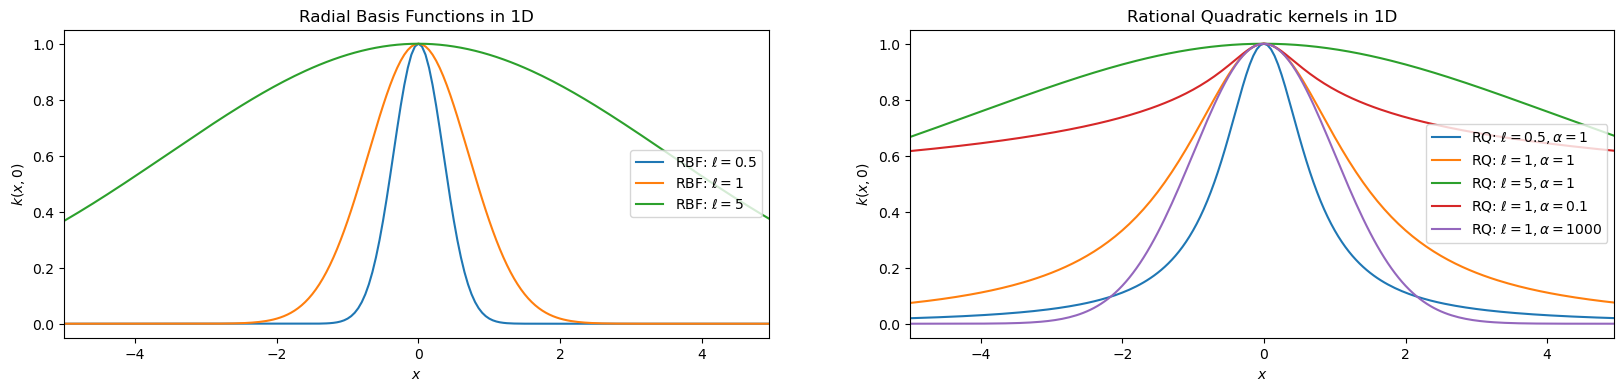

In [2]:
from reusable.kernels import rbf_kernel, rq_kernel
import matplotlib.pyplot as plt
import jax.numpy as jnp

lim = 5
step = lim /100
x= jnp.arange(-lim, lim, step)

fig, axs = plt.subplots(1, 2, figsize=(20,4))

for l in [0.5, 1, 5]:
    axs[0].plot(x,[rbf_kernel(0,y, l) for y in x], label=f"RBF: $\ell={l}$")


axs[0].set_title("Radial Basis Functions in 1D")
axs[0].set_ylabel("$k(x,0)$")
axs[0].set_xlabel("$x$")
axs[0].legend(loc=5)
axs[0].margins(x=0)

for l in [0.5, 1, 5]:
    axs[1].plot(x,[rq_kernel(0,y, l, 1) for y in x], label=f"RQ: $\ell={l}, \\alpha=1$")
for l in [0.1, 1000]:
    axs[1].plot(x,[rq_kernel(0,y, 1, l) for y in x], label=f"RQ: $\ell=1,\\alpha={l}$")

axs[1].set_title("Rational Quadratic kernels in 1D")
axs[1].set_ylabel("$k(x,0)$")
axs[1].set_xlabel("$x$")
axs[1].legend(loc=5)
axs[1].margins(x=0)

fig.savefig("./gen_plots/10_kernels_plots.pdf", dpi=300)

In [5]:
from reusable.vae import VAE
import jax.random
import functools

model = VAE(35, 32, 30, 100, False, False)
batch = jnp.ones((100,))  # (N, H, W, C) format
variables = model.init(jax.random.PRNGKey(0), batch)

f=functools.partial(model.apply, variables)
# z=jax.xla_computation(f)(batch)

# with open("t2.dot", "w") as f:
#     f.write(z.as_hlo_dot_graph())

print(jax.eval_shape(f, batch))

(ShapeDtypeStruct(shape=(100,), dtype=float32), ShapeDtypeStruct(shape=(100,), dtype=float32), ShapeDtypeStruct(shape=(30,), dtype=float32), ShapeDtypeStruct(shape=(30,), dtype=float32))
